In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, RobustScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [3]:
def evaluate_model(model, X_train, y_train, X_test, y_test, class_names=['Ia','Ibc','II']):
  print("The training set:")
  y_train_pred = model.predict(X_train)
  print("\n Validation accuracy: ", accuracy_score(y_train, y_train_pred))
  print("\n Classification report:\n ",classification_report(y_train, y_train_pred))
  print("\n Confusion matrix:\n", confusion_matrix(y_train, y_train_pred))

  print("\nThe test set:")
  y_test_pred = model.predict(X_test)
  print("\n Validation accuracy: ", accuracy_score(y_test, y_test_pred))
  print("\n Classification report:\n ",classification_report(y_test, y_test_pred))
  print("\n Confusion matrix: \n", confusion_matrix(y_test, y_test_pred))

  # ---- ROC Curve ----
  classes = model.classes_
  n_classes = len(classes)
  y_test_bin = label_binarize(y_test, classes=classes)
  y_score = model.predict_proba(X_test)

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure(figsize=(7,6))
  colors = plt.cm.get_cmap('Set1', n_classes)
  for i in range(n_classes):
    label = f"Class {i}" if class_names is None else class_names[i]
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'{label} (AUC = {roc_auc[i]:.2f})')

  plt.plot([0,1], [0,1], 'k--', lw=1)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-class ROC Curve')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

In [4]:
# load data
Ia = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/ML_master_table_TypeIa.csv')
Ibc = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/ML_master_table_TypeIbc.csv')
II = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/ML_master_table_TypeII.csv')

Attempt 1: Original data

In [5]:
data = pd.concat([Ia, Ibc, II], ignore_index=True)
data = data.dropna()
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

skip = {'sn_name', 'sn_type', 'band'}
feature_cols = [c for c in data.columns if c not in skip]

# features
X = data[feature_cols]

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

X = X.clip(lower=lower, upper=upper, axis=1)

# labels
y = data['sn_type']
print("Unique mapped labels:", y.unique())

name_Ia = ['Ia','IaQ','Ia_Pec']
name_II = ['II','II_P','IIP','IIQ','II_L','II_Pec']

y = y.apply(lambda v: 0 if v in name_Ia else (2 if v in name_II else 1))

# count examples in classes
pd.Series(y).value_counts()

Unique mapped labels: ['II' 'Ia' 'Ib_c' 'Ib' 'Ia_Pec' 'IaQ' 'Ic' 'Ic_Pec' 'II_P' 'IIQ' 'IIP'
 'Ib-pec' 'II_L' 'IcQ' 'II_Pec' 'Ic/Ic-BL']


,count
sn_type,
0,12590
2,12447
1,600


In [6]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y,
    shuffle=True
)

scaler = RobustScaler()
X_train1 = scaler.fit_transform(X_train1)
X_test1 = scaler.transform(X_test1)

In [7]:
svm1 = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)
svm1.fit(X_train1, y_train1)

SVC(class_weight='balanced', probability=True)

The training set:

 Validation accuracy:  0.5726266517138817

 Classification report:
                precision    recall  f1-score   support

           0       0.72      0.48      0.57     10072
           1       0.06      0.58      0.10       480
           2       0.75      0.67      0.71      9957

    accuracy                           0.57     20509
   macro avg       0.51      0.58      0.46     20509
weighted avg       0.72      0.57      0.63     20509


 Confusion matrix:
 [[4809 3079 2184]
 [ 119  278   83]
 [1747 1553 6657]]

The test set:

 Validation accuracy:  0.5774180967238689

 Classification report:
                precision    recall  f1-score   support

           0       0.73      0.49      0.59      2518
           1       0.05      0.52      0.09       120
           2       0.75      0.66      0.70      2490

    accuracy                           0.58      5128
   macro avg       0.51      0.56      0.46      5128
weighted avg       0.72      0.58      0.63 

/tmp/ipython-input-3970579071.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


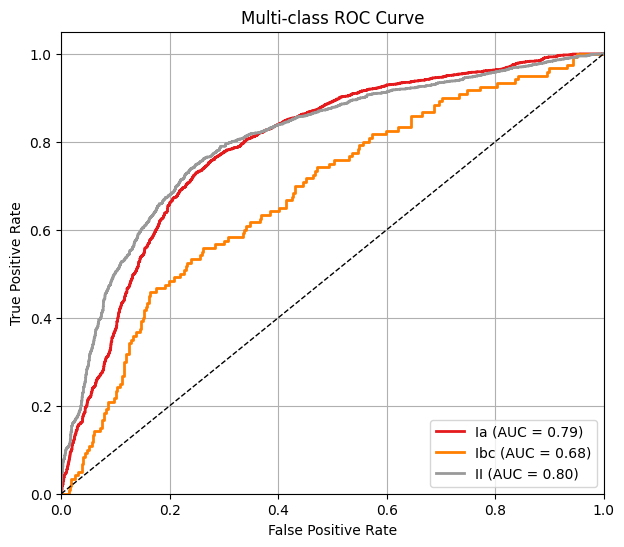

In [8]:
evaluate_model(svm1, X_train1, y_train1, X_test1, y_test1)

Attempt 2: Downsampling

In [9]:
Ia_down = Ia.sample(1000)
II_down = II.sample(1000)

data_down = pd.concat([Ia_down, Ibc, II_down], ignore_index=True)
data_down = data_down.dropna()
data_down = data_down.sample(frac=1, random_state=42).reset_index(drop=True)

# features
X_down = data_down[feature_cols]

Q1 = X_down.quantile(0.25)
Q3 = X_down.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

X_down = X_down.clip(lower=lower, upper=upper, axis=1)

# labels
y_down = data_down['sn_type']
print("Unique mapped labels:", y_down.unique())

y_down = y_down.apply(lambda v: 0 if v in name_Ia else (2 if v in name_II else 1))

# count examples in classes
pd.Series(y_down).value_counts()

Unique mapped labels: ['Ia' 'II' 'Ib_c' 'Ic' 'IcQ' 'Ib' 'II_P' 'Ic_Pec' 'IIQ' 'IaQ' 'Ib-pec'
 'IIP' 'II_Pec' 'Ic/Ic-BL' 'Ia_Pec']


,count
sn_type,
0,1000
2,983
1,600


In [10]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_down, y_down,
    test_size=0.2,
    random_state=42,
    stratify=y_down,
    shuffle=True
)

scaler = RobustScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

In [11]:
svm2 = SVC(
    kernel='rbf',
    #degree=6,
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    probability=True)

svm2.fit(X_train2, y_train2)

SVC(class_weight='balanced', probability=True)

The training set:

 Validation accuracy:  0.5546950629235237

 Classification report:
                precision    recall  f1-score   support

           0       0.60      0.40      0.48       800
           1       0.39      0.58      0.47       480
           2       0.67      0.70      0.69       786

    accuracy                           0.55      2066
   macro avg       0.55      0.56      0.54      2066
weighted avg       0.58      0.55      0.55      2066


 Confusion matrix:
 [[317 302 181]
 [116 280  84]
 [ 99 138 549]]

The test set:

 Validation accuracy:  0.5493230174081238

 Classification report:
                precision    recall  f1-score   support

           0       0.62      0.39      0.47       200
           1       0.38      0.62      0.47       120
           2       0.67      0.68      0.67       197

    accuracy                           0.55       517
   macro avg       0.56      0.56      0.54       517
weighted avg       0.58      0.55      0.55       517

/tmp/ipython-input-3970579071.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


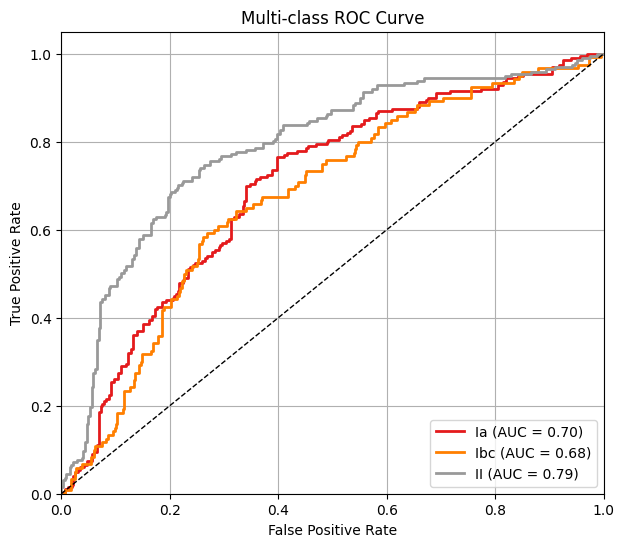

In [12]:
evaluate_model(svm2, X_train2, y_train2, X_test2, y_test2)